### Reading csvs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
from collections import defaultdict
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer

In [64]:
#nltk.download('wordnet')

In [23]:

df1 = pd.read_csv('./dataset/software_requirements_extended.csv')

# Creating final csv with combined requirements
final_df = pd.DataFrame(pd.concat([df1['Requirement']] ,ignore_index=True).str.replace("'",""))
final_df.rename({0:"Requirement"},axis=1,inplace=True)
final_df.drop_duplicates(subset=['Requirement'])
final_df.head()

,Requirement
0,The system shall refresh the display every 60 ...
1,The application shall match the color of the s...
2,If projected the data must be readable. On ...
3,The product shall be available during normal ...
4,If projected the data must be understandable...


In [24]:
# Use for the first time only 

#final_df.to_csv("./dataset/final_combined2.csv")
final_df = pd.read_csv("./dataset/final_combined2.csv").reset_index()
del final_df['Unnamed: 0']
final_df = final_df.drop(['index'], axis=1)

In [25]:
final_df.dropna()
final_df.describe()

,Requirement
count,977
unique,976
top,Only registered customers can purchase streami...
freq,2


## General EDA

In [26]:

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

In [27]:
# Character count 
final_df['char_count'] = final_df['Requirement'].map(lambda x: len(x))
# Word counts
final_df["word_count"] = final_df["Requirement"].map(lambda x: len(x.split()))
# String counts
final_df["hashtag_count"] = final_df["Requirement"].map(lambda x: x.count("#"))
# Average word length
final_df["avg_word_len"] = final_df["Requirement"].map(lambda x: np.mean([len(w) for w in str(x).split()]))

final_df.head(10)

,Requirement,char_count,word_count,hashtag_count,avg_word_len
0,The system shall refresh the display every 60 ...,54,9,0,5.111111
1,The application shall match the color of the s...,96,16,0,5.062500
2,If projected the data must be readable. On ...,160,30,0,4.233333
3,The product shall be available during normal ...,197,36,0,4.444444
4,If projected the data must be understandable...,204,35,0,4.771429
5,The product shall ensure that it can only be a...,180,29,0,5.206897
6,The product shall be intuitive and self-explan...,54,7,0,6.571429
7,The product shall respond fast to keep up-to-d...,70,12,0,4.916667
8,The system shall have a MDI form that allows f...,93,19,0,3.947368
9,The system shall display Events in a vertical ...,60,11,0,4.545455


<Axes: xlabel='avg_word_len', ylabel='Count'>

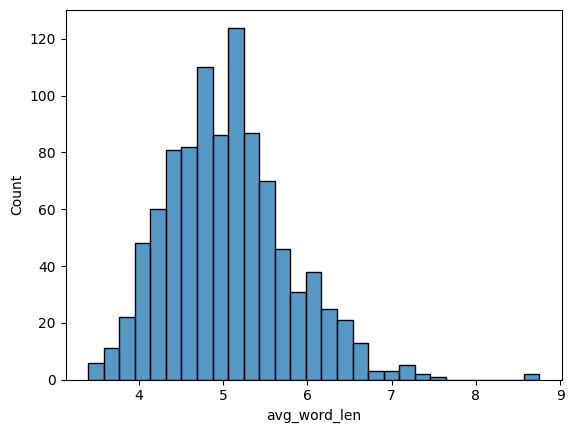

In [28]:
sns.histplot(final_df, x='avg_word_len')

In [29]:
# cleaning the data
import re
import string
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    # Remove non-Roman characters
    text = re.sub("([^\x00-\x7F])+", " ", text)
    
    text = ''.join([char if ord(char) < 128 else '' for char in text])
    
    return text

In [30]:
final_df["text_clean"] = final_df["Requirement"].map(lambda x: clean_text(x))
final_df.head()

,Requirement,char_count,word_count,hashtag_count,avg_word_len,text_clean
0,The system shall refresh the display every 60 ...,54,9,0,5.111111,the system shall refresh the display every 60 ...
1,The application shall match the color of the s...,96,16,0,5.062500,the application shall match the color of the s...
2,If projected the data must be readable. On ...,160,30,0,4.233333,if projected the data must be readable on a...
3,The product shall be available during normal ...,197,36,0,4.444444,the product shall be available during normal ...
4,If projected the data must be understandable...,204,35,0,4.771429,if projected the data must be understandable...


In [31]:
# For generating word cloud
from wordcloud import WordCloud
from textwrap import wrap

def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()

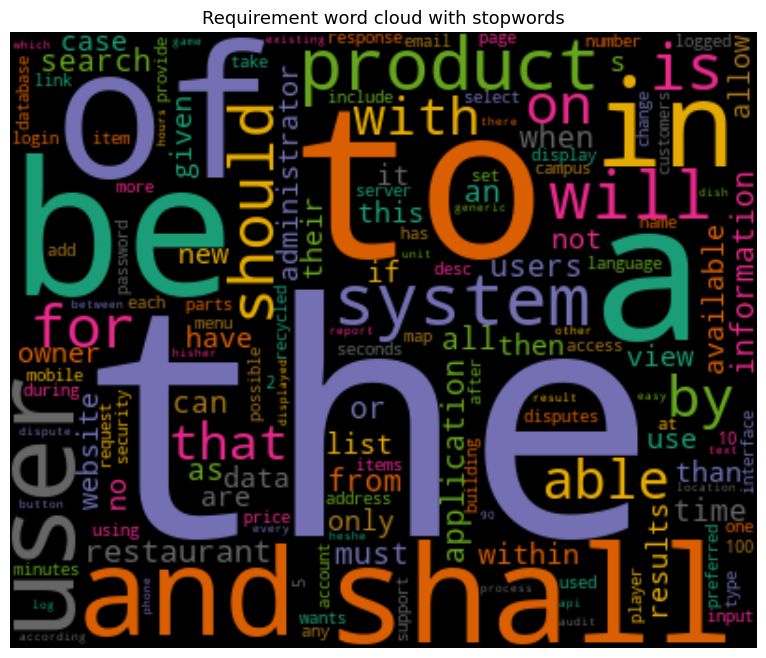

In [32]:
before_clean_words = final_df['text_clean'].str.split()
before_clean_words = before_clean_words.values.tolist()
wordlist =[word for i in before_clean_words for word in i]

from collections import defaultdict

word_dict_with_stopwords=defaultdict(int)
for word in wordlist:
        word_dict_with_stopwords[word]+=1


generate_wordcloud(word_dict_with_stopwords, 'Requirement word cloud with stopwords')

> ### Lemmatizing

In [33]:
# Lemmatizing
lemmatizer = WordNetLemmatizer()

def apply_lemmatize(text):
    
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

final_df['Requirement'] = final_df['Requirement'].apply(apply_lemmatize)

final_df['Requirement'].head()

0    The system shall refresh the display every 60 ...
1    The application shall match the color of the s...
2    If projected the data must be readable. On a 1...
3    The product shall be available during normal b...
4    If projected the data must be understandable. ...
Name: Requirement, dtype: object

> ### Removing Stopwords

In [41]:
# creating a corpus with removed stopwords
#nltk.download('stopwords')
stop=set(stopwords.words('english'))
corpus = [ word for i in final_df["text_clean"].str.split().values.tolist() for word in i if (word not in stop) ]
final_df['without_stopwords'] = final_df['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
corpus[:10]

['system',
 'shall',
 'refresh',
 'display',
 'every',
 '60',
 'seconds',
 'application',
 'shall',
 'match']

In [35]:
# get 15 first most common words from the corpus
common_words = FreqDist(corpus).most_common(15)
common_words

[('shall', 469),
 ('user', 303),
 ('product', 288),
 ('system', 273),
 ('able', 151),
 ('restaurant', 128),
 ('search', 111),
 ('application', 107),
 ('must', 106),
 ('information', 99),
 ('users', 98),
 ('time', 94),
 ('administrator', 80),
 ('owner', 76),
 ('use', 74)]

<Axes: >

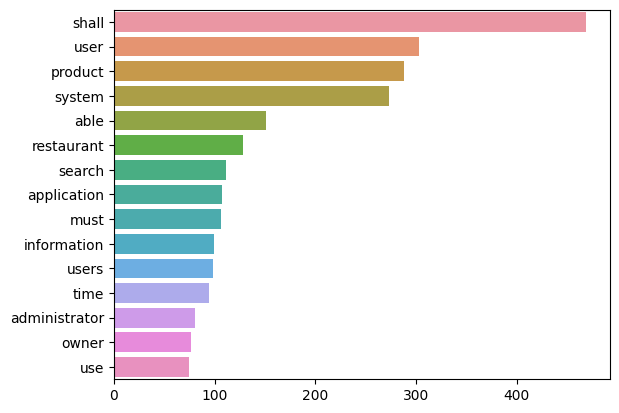

In [38]:
# creating plots for most common words 
words, frequency = [], []
word_freq_dict = {}    
for word, count in common_words:
    words.append(word)
    frequency.append(count)
    word_freq_dict[word] = count

sns.barplot(x = frequency, y = words)

# we can conclude from this graph that generally people don't ask about specific requirement they ususally talk about system as a whole.
# from frequency of "able" and "allow" we can also say that users want security for their application
# from word "data" we can say that people are concerned about the storage and security of the data
# "restaurant" is somewhat strange, maybe there are lot of requirements from the restaurant businesses?

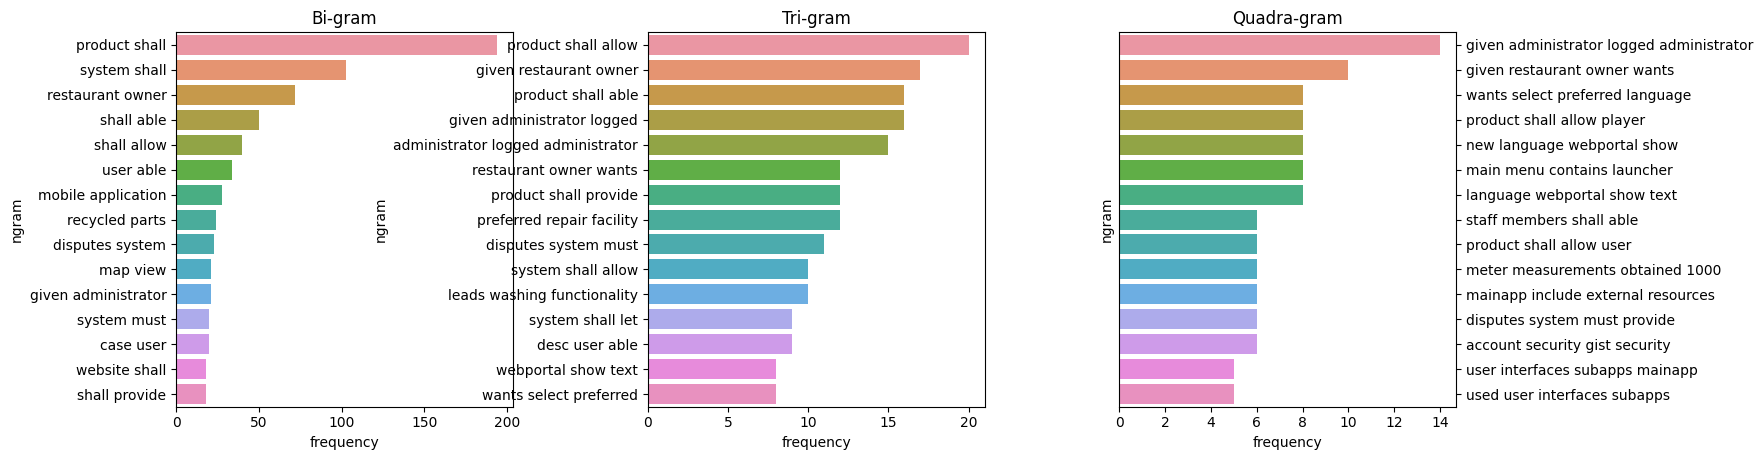

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
def convert_ngram(ngram_range):
    vec = CountVectorizer(stop_words= list(stop), ngram_range=ngram_range)
    # Matrix of ngrams
    bow = vec.fit_transform(final_df["text_clean"])
    # Count frequency of ngrams
    count_values = bow.toarray().sum(axis=0)
    # Create DataFrame from ngram frequencies
    ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in vec.vocabulary_.items()], reverse = True))
    ngram_freq.columns = ["frequency", "ngram"]
    return ngram_freq

bi_ngram = convert_ngram((2,2))
tri_gram = convert_ngram((3,3))
qudra_gram = convert_ngram((4,4))
fig, axis = plt.subplots(1,3)
sns.barplot(data=bi_ngram, y=bi_ngram['ngram'][:15],x=bi_ngram['frequency'][:15], ax=axis[0])
sns.barplot(data=tri_gram, y=tri_gram['ngram'][:15],x=tri_gram['frequency'][:15], ax=axis[1])
sns.barplot(data=qudra_gram, y=qudra_gram['ngram'][:15],x=qudra_gram['frequency'][:15], ax=axis[2])

axis[0].set_title('Bi-gram')
axis[1].set_title('Tri-gram')
axis[2].set_title('Quadra-gram')
axis[2].yaxis.tick_right()
plt.subplots_adjust(left=0.5,
                    bottom=0.1,
                    right=2.5,
                    wspace=0.4,
                    hspace=0.4)



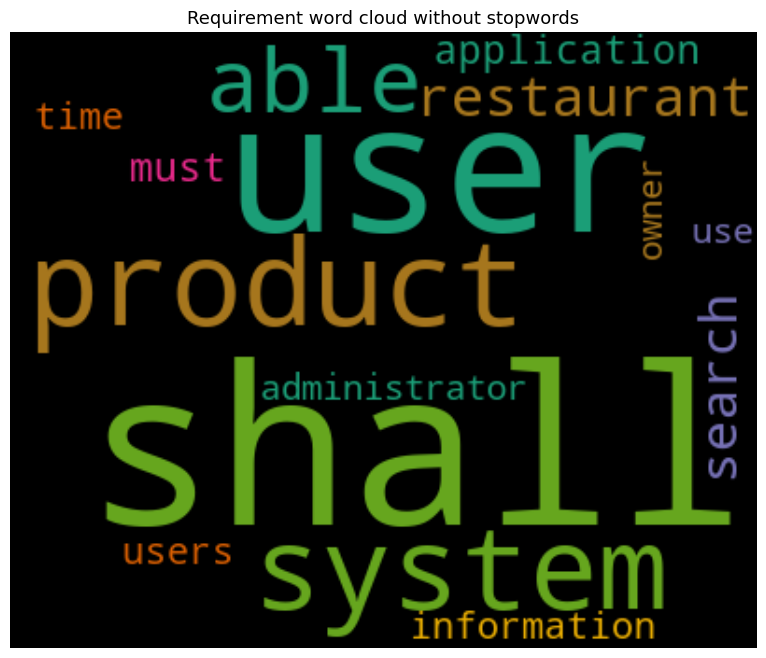

In [39]:
# word cloud after filtering

generate_wordcloud(word_freq_dict, 'Requirement word cloud without stopwords')